# data processing


Before beeing usable for analysis, our data has to be cleaned of undefined and outlier values

In [163]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math 
import seaborn as sns
from pandas.plotting import scatter_matrix

#data = pd.read_csv('data/processed/merged_data.csv', index_col=['Country', 'Year'])
data = pd.read_csv('data/processed/merged_data.csv')
data.set_index(['Country', 'Year'])
#data.reset_index()
# drop useless culumns
data.drop(columns=['Last Updated: 11/14/2018', 'Data from database: World Development Indicators'], inplace=True)



#rename variable names
# rename columns for convenience
data.rename(index=str, columns={'Life expectancy at birth (years)  Both sexes': 'LE_both'}, inplace=True)
data.rename(index=str, columns={'Life expectancy at birth (years)  Male': 'LE_male'}, inplace=True)
data.rename(index=str, columns={'Life expectancy at birth (years)  Female': 'LE_female'}, inplace=True)
data.rename(columns={'Current health expenditure (CHE) per capita in US$': 'CHE_in_USD'}, inplace=True)

print(data.columns)


Index(['Country', 'Year', 'LE_both', 'LE_male', 'LE_female', 'Income Level',
       'GDP per Capita', 'Surface area (sq. km)', 'Population, total',
       'Population density (people per sq. km of land area)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Mortality caused by road traffic injury (per 100,000 people)',
       'Intentional homicides (per 100,000 people)',
       'Individuals using the Internet (% of population)',
       'Incidence of tuberculosis (per 100,000 people)',
       'GNI, Atlas method (current US$)', 'GDP per capita growth (annual %)',
       'GDP growth (annual %)', 'CO2 emissions (metric tons per capita)',
       'Access to electricity (% of population)', 'CHE_in_USD',
       'Research and development expenditure (% of GDP)'],
      dtype='object')


## Cleaning

We analyse the variables for NaN Values and implement strategies to avoid them. Since we collected Data over a period of 18 years, we have enought to safely delete some Datapoints.

### Income Level

For some Countries, the variable 'Income-Level' is missing. Since this variable is vital for analysis, we closely inspect these values. We discover that besides "Timor-Leste", where we can guess a sensible value, data is very sparse for this countries. We decide to drop them all together!

In [164]:


# Income level unknown, set to NaN
data.loc[data['Income Level'] == 'Unknown', 'Income Level'] = np.nan

#Timor-Leste
tl = data.groupby('Country')['Income Level'].last()['Timor-Leste']
data.loc[(data['Country'] == 'Timor-Leste') & (data['Year'] == 2000), 'Income Level'] = tl
#data.set_value(2770, 'Income Level', 'L')


# Delete this countries
delcon = data.loc[data['Income Level'].isnull(), 'Country'].unique().tolist()
# also delete this countries
delcon.append('Democratic People\'s Republic of Korea')
delcon.append('Somalia')
print(delcon)
data = data[~data['Country'].isin(delcon)]

# compress data by country
data_bycountry = data.sort_values(by=['Year']).groupby(['Country'])
data_last = data_bycountry.last()

# nan
print(data_last.isnull().sum())
data_last.drop(columns=['Research and development expenditure (% of GDP)'], inplace=True)


['Montenegro', 'Sao Tome and Principe', 'Serbia', 'South Sudan', "Democratic People's Republic of Korea", 'Somalia']
Year                                                                       0
LE_both                                                                    0
LE_male                                                                    0
LE_female                                                                  0
Income Level                                                               0
GDP per Capita                                                             0
Surface area (sq. km)                                                      0
Population, total                                                          0
Population density (people per sq. km of land area)                        0
PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)     0
Mortality caused by road traffic injury (per 100,000 people)               0
Intentional homicides (per 100,000 p

### Time Series Data

To clean our tile-series-data from NaN values is not so easy becouse we have to consider a time period of 18 years. If there is a gap between available values we could interpolate the missing values. 

In [165]:
nans = [[]]
delcol = ['GDP per Capita',
          'GNI, Atlas method (current US$)',
          'GDP per capita growth (annual %)',
          'GDP growth (annual %)',
          'Access to electricity (% of population)', 
          'CO2 emissions (metric tons per capita)', 
          'Individuals using the Internet (% of population)', 
          'Mortality caused by road traffic injury (per 100,000 people)', 
          'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
          'Research and development expenditure (% of GDP)', 'CHE_in_USD', 
          'Intentional homicides (per 100,000 people)', 
          'Mortality caused by road traffic injury (per 100,000 people)',
          'Incidence of tuberculosis (per 100,000 people)']


for col in delcol:
    print(col)
    print(data[col].isnull().sum())
    d[col] = data[col].interpolate()
    
    

#'Individuals using the Internet (% of population)', 
d = d.drop(columns=['CO2 emissions (metric tons per capita)'])
#d = data.drop(columns=delcon)
d = d[(d['Year'] >= 2000) & (d['Year'] <= 2018)]


# 
delcon = ['Albania', 'Eritrea', 'Syrian Arab Republic', 'Venezuela (Bolivarian Republic of)', 'Djibouti', 'Libya', 'Iraq', 'Afghanistan']
print(delcon)
d = d[~d['Country'].isin(delcon)]

# 'Research and development expenditure (% of GDP)' no data for albaniea


# CHE_in_USD no data in 2016
# what do?

print(d.isnull().sum())

data_time = d

GDP per Capita
22
GNI, Atlas method (current US$)
55
GDP per capita growth (annual %)
36
GDP growth (annual %)
36
Access to electricity (% of population)
12
CO2 emissions (metric tons per capita)
360
Individuals using the Internet (% of population)
39
Mortality caused by road traffic injury (per 100,000 people)
2301
PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)
1416
Research and development expenditure (% of GDP)
1694
CHE_in_USD
201
Intentional homicides (per 100,000 people)
877
Mortality caused by road traffic injury (per 100,000 people)
2301
Incidence of tuberculosis (per 100,000 people)
2
['Albania', 'Eritrea', 'Syrian Arab Republic', 'Venezuela (Bolivarian Republic of)', 'Djibouti', 'Libya', 'Iraq', 'Afghanistan']
Country                                                                   0
Year                                                                      0
LE_both                                                                   0
LE_male            

## Detecting Outliers

We examined our data for Outliers using visual methods, specially boxplots.

### Boxplots

We detect outliers by plotting a boxplot for every variable and deciding if there are outliers und what du do with them.

For variables with skewed Distribution we Transform the variable and look at the boxplots again.

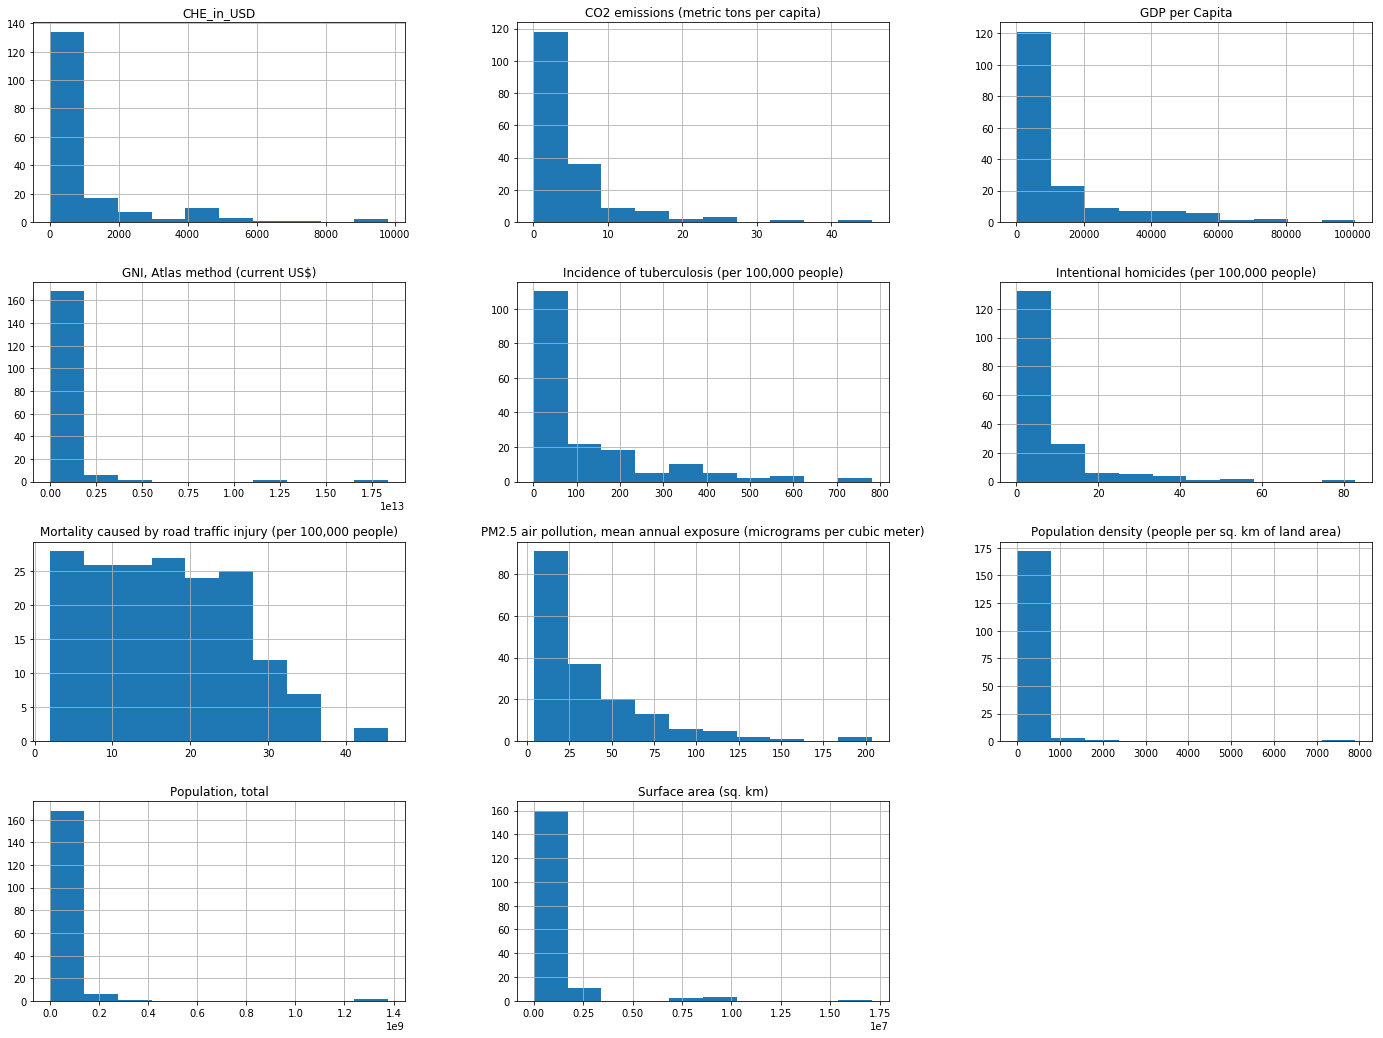

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029BFE9FFF28>,
      dtype=object)

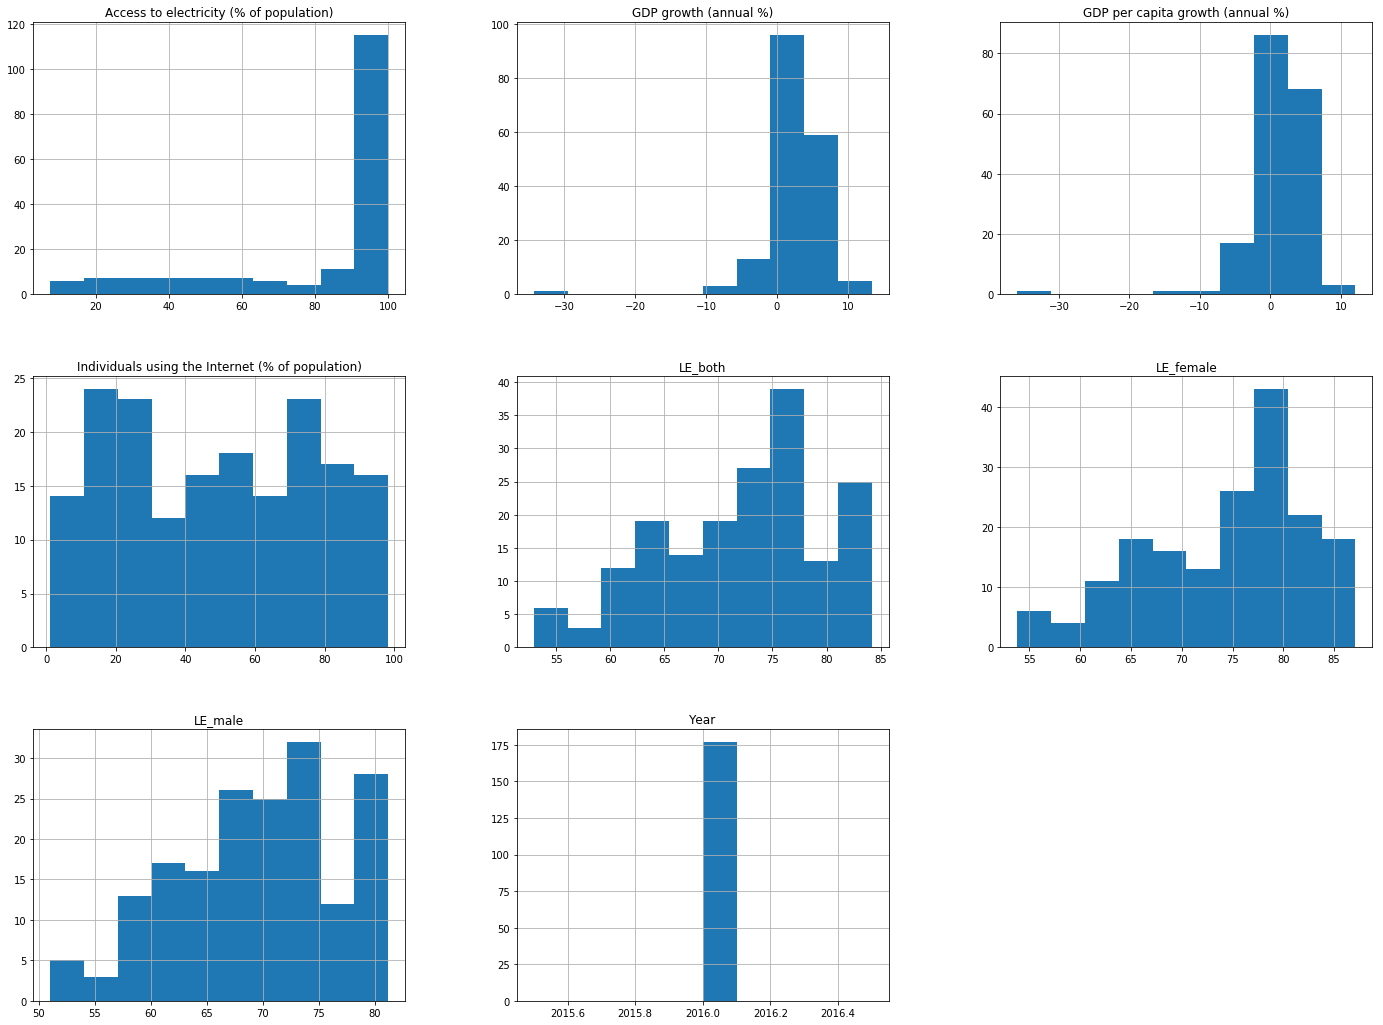

In [166]:
cols = ['Surface area (sq. km)',
        'Population, total',
        'Population density (people per sq. km of land area)',
        'GDP per Capita', 
        'GNI, Atlas method (current US$)',
#       'GDP per capita growth (annual %)', 'GDP growth (annual %)',
        'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
        'Mortality caused by road traffic injury (per 100,000 people)',
        'Intentional homicides (per 100,000 people)',
        'Incidence of tuberculosis (per 100,000 people)',
        'CO2 emissions (metric tons per capita)',
        'CHE_in_USD']

fig = data_last[cols].hist(figsize=(24, 18))
plt.show()

data_last.loc[:, ~data_last.columns.isin(cols)].hist(figsize=(24, 18))

Surface area (sq. km)


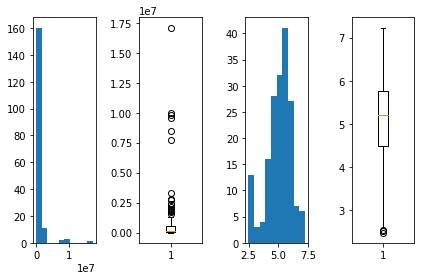

Population, total


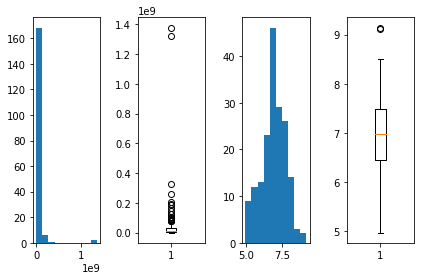

Population density (people per sq. km of land area)


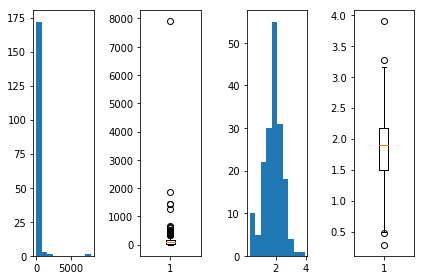

GDP per Capita


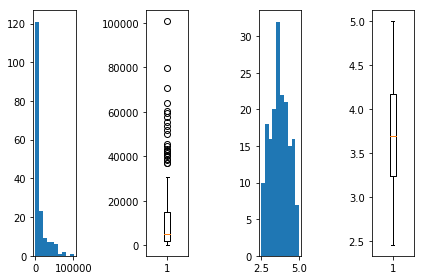

GNI, Atlas method (current US$)


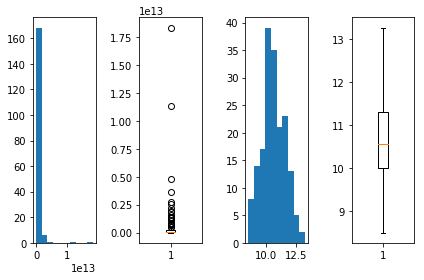

PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)


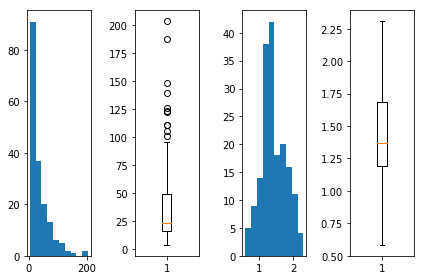

Mortality caused by road traffic injury (per 100,000 people)


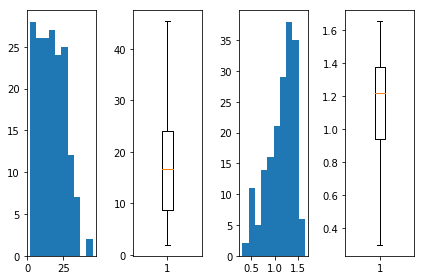

Intentional homicides (per 100,000 people)


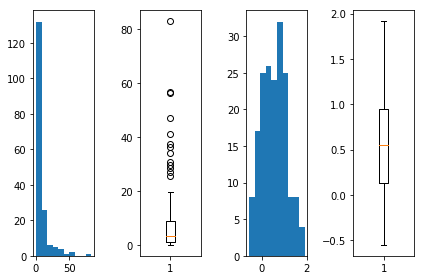

Incidence of tuberculosis (per 100,000 people)


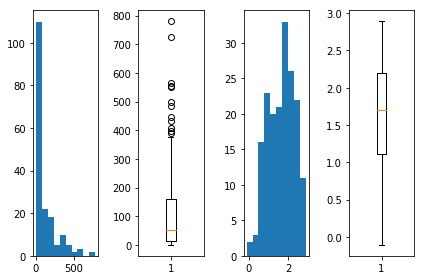

CO2 emissions (metric tons per capita)


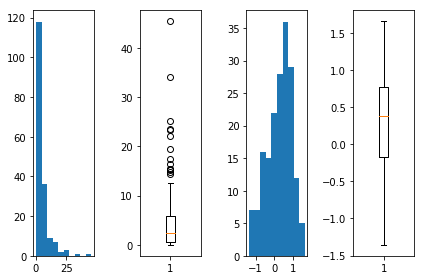

CHE_in_USD


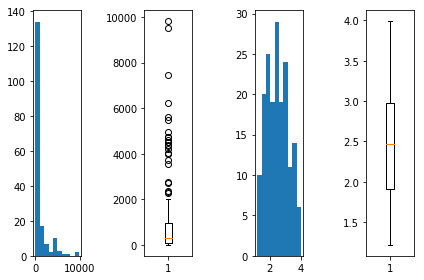

In [167]:





def mplt(data1, data2):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    n, bins, patches = ax1.hist(data1)
    o = ax2.boxplot(data1)
    n, bins, patches = ax3.hist(data2)
    o = ax4.boxplot(data2)
    fig.tight_layout()
    plt.show()

    
    
data_transformed = data_last.copy()



for ser in cols:
    print(ser)
    data_transformed[ser] = data_last[ser].transform(math.log10)
    
    mplt(data_last[ser], data_transformed[ser])




We can see there are outliers in 'Population, total'

In [168]:
display(data_last.sort_values('Population, total', ascending=False).head(2))

,Year,LE_both,LE_male,LE_female,Income Level,GDP per Capita,Surface area (sq. km),"Population, total",Population density (people per sq. km of land area),"PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)","Mortality caused by road traffic injury (per 100,000 people)","Intentional homicides (per 100,000 people)",Individuals using the Internet (% of population),"Incidence of tuberculosis (per 100,000 people)","GNI, Atlas method (current US$)",GDP per capita growth (annual %),GDP growth (annual %),CO2 emissions (metric tons per capita),Access to electricity (% of population),CHE_in_USD
Country,,,,,,,,,,,,,,,,,,,,
China,2016,76.4,75.0,77.9,UM,8117.267465,9562911.0,1.378665e+09,146.850662,56.330148,19.4,0.615601,53.200000,64.0,1.138044e+13,6.123804,6.700000,7.543908,100.000000,425.6
India,2016,68.8,67.4,70.3,LM,1717.473878,3287259.0,1.324171e+09,445.370580,75.800791,21.2,3.223699,29.547163,211.0,2.224660e+12,5.889836,7.112686,1.730000,84.526817,63.3


In [169]:

col = 'Access to electricity (% of population)'

data_last[col].describe()

count    177.000000
mean      82.008503
std       27.620997
min        7.588477
25%       65.790207
50%      100.000000
75%      100.000000
max      100.000000
Name: Access to electricity (% of population), dtype: float64

In [170]:
data_last.to_csv('data/processed/data_flat_clean.csv')
data_transformed.to_csv('data/processed/data_flat_clean_transformed.csv')
data_time.to_csv('data/processed/data_time_clean.csv')